In [1]:
from model_utils import *

In [2]:
MODEL_NAME = 'skimai/spanberta-base-cased'
FILE = 'data/cleaned_labeled_data_v3.json'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128
LEARN_RATE = 4e-5
EPOCH = 5
MAX_CATE_SIZE = 4000
DATASET_NAME = 'NewCate'
TASK = 'NewsCate-raw'

In [3]:
import datetime
TODAY = datetime.date.today().strftime("%m%d")
RESULT_DIR = 'results/{}-results-{}'.format(TASK,TODAY)
SUB_DIR = '/{}-{}'.format(LEARN_RATE, MAX_SEQ_LENGTH)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)
if not os.path.exists("{}{}".format(RESULT_DIR,SUB_DIR)):
    os.makedirs("{}{}".format(RESULT_DIR,SUB_DIR))
OUTPUT_PATH = RESULT_DIR + SUB_DIR

In [4]:
target_label = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']

## Train

init

In [5]:
# load data
labels,contents,lset,ldic = load_data(FILE,MAX_CATE_SIZE,target_label)

# encode 1 87s
start = time.time()
encodings_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print('encoding time cost :',time.time()-start)

# load dataset
train_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic)
valid_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic, 'val')
test_dataset = NewsCategoryDataset(labels, encodings_list, contents, ldic, 'test')
print('data loaded \ntrain:{}\nvalid:{}\ntest:{}'.format(len(train_dataset),
                                                          len(valid_dataset),
                                                          len(test_dataset)))

# dataloader
train_val_loaders = {
    "train": DataLoader(dataset=train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True),
    "valid": DataLoader(dataset=valid_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False),
    "test": DataLoader(dataset=test_dataset,
                       batch_size=BATCH_SIZE,
                       shuffle=False)
}

Data loaded:  86238 86238


100%|██████████| 86238/86238 [00:21<00:00, 4062.41it/s]

Tokenizer loaded...
encoding time cost : 26.3269464969635
data loaded 
train:60366
valid:12937
test:12935


## 1.From pre-training

In [6]:
model = RobertaForSequenceClassification(MODEL_NAME,len(ldic))
model.MLP.apply(weight_init)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()

## 2.Going on

In [7]:
model = RobertaForSequenceClassification(MODEL_NAME,len(lset))
state_dict = torch.load('./results/3.699999999999999e-05-128/5-18-epoch-4.pth')
model.load_state_dict(state_dict)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=LEARN_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

acclist,losslist = train_classifier(model,EPOCH,LEARN_RATE, MAX_SEQ_LENGTH,
                                    train_val_loaders,criterion,TODAY,
                                    optimizer,scheduler,path=OUTPUT_PATH)

epoch 0


  0%|          | 0/472 [00:00<?, ?it/s]

Epoch 0 batch 471, loss: 1.399 acc: 56.4103 
validating...
After Epoch 0 , valid acc: 0.6103424286928963, avg loss1.7581142618999643  avg acc0.4999537395425902
epoch 1


  0%|          | 0/472 [00:00<?, ?it/s]

Epoch 1 batch 471, loss: 1.286 acc: 62.8205  
validating...
After Epoch 1 , valid acc: 0.6486047769962124, avg loss1.4470595562735857  avg acc0.5839398121740548
epoch 2


  0%|          | 0/472 [00:00<?, ?it/s]

Epoch 2 batch 471, loss: 1.007 acc: 69.2308  
validating...
After Epoch 2 , valid acc: 0.6557161629434954, avg loss1.2484554749003238  avg acc0.6374814109354628
epoch 3


  0%|          | 0/472 [00:00<?, ?it/s]

Epoch 3 batch 471, loss: 0.7122 acc: 80.7692 
validating...
After Epoch 3 , valid acc: 0.6548658885367551, avg loss1.0922149659087093  avg acc0.6803686746251629
epoch 4


  0%|          | 0/472 [00:00<?, ?it/s]

Epoch 4 batch 471, loss: 0.5996 acc: 79.4872 
validating...
After Epoch 4 , valid acc: 0.6480636932828322, avg loss0.9586332604099633  avg acc0.7174237254182964


## Check Acc and Loss

In [8]:
batch_step = 50
new_acc = acclist[0::batch_step]
new_loss = losslist[0::batch_step]

In [9]:
import matplotlib.pyplot as plt

In [10]:
x_label = [i*batch_step for i in range(len(new_acc))]
new_acc = [np.mean(np.array(acclist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_acc))]
loss_acc = [np.mean(np.array(losslist[i*batch_step:(i+1)*batch_step])) for i in range(len(new_loss))]

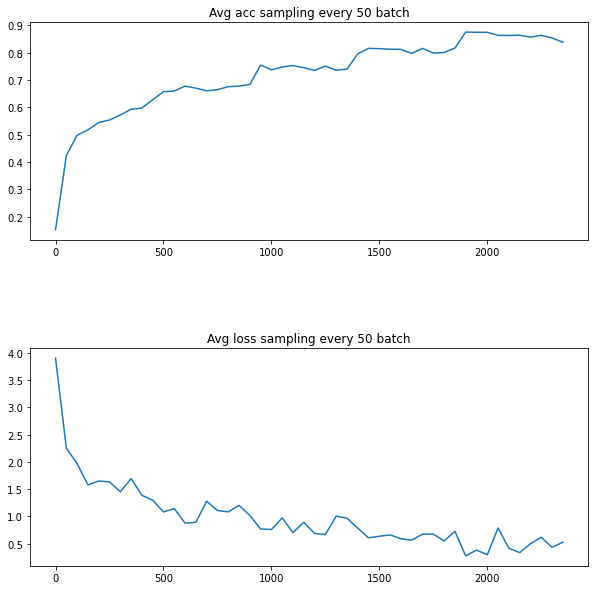

<Figure size 432x288 with 0 Axes>

In [11]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1,)
ax1.plot(x_label,new_acc)
ax1.set_title('Avg acc sampling every {} batch'.format(batch_step))
ax2 = plt.subplot(2,1,2,sharex=ax1)
ax2.plot(x_label,new_loss)
ax2.set_title('Avg loss sampling every {} batch'.format(batch_step))
plt.subplots_adjust(wspace =0, hspace =0.5)
plt.show()
plt.savefig('./img/{}-{}-acc-loss.jpg'.format(LEARN_RATE,MAX_SEQ_LENGTH))

## Visualization

In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
iterator = train_val_loaders
true_labels = []
pred_outputs = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator['test'])):
        
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].to('cuda')
        targets = data['targets']
        targets.numpy()
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs,axis=1)
        '''
        # print screen 
        for i in range(len(data)):
            print(data['origin_contents'][i])
            print('pred: ',lset[outputs[i]])
            print('true: ',lset[targets[i]])
            print('--------------')
        
        '''
        
        pred_outputs += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_outputs))
    print(pred_outputs[:15])

  0%|          | 0/102 [00:00<?, ?it/s]

12935
[7, 23, 10, 9, 5, 4, 7, 25, 3, 16, 21, 12, 13, 4, 13]
12935
[7, 18, 4, 9, 5, 4, 7, 25, 3, 11, 21, 12, 21, 4, 13]


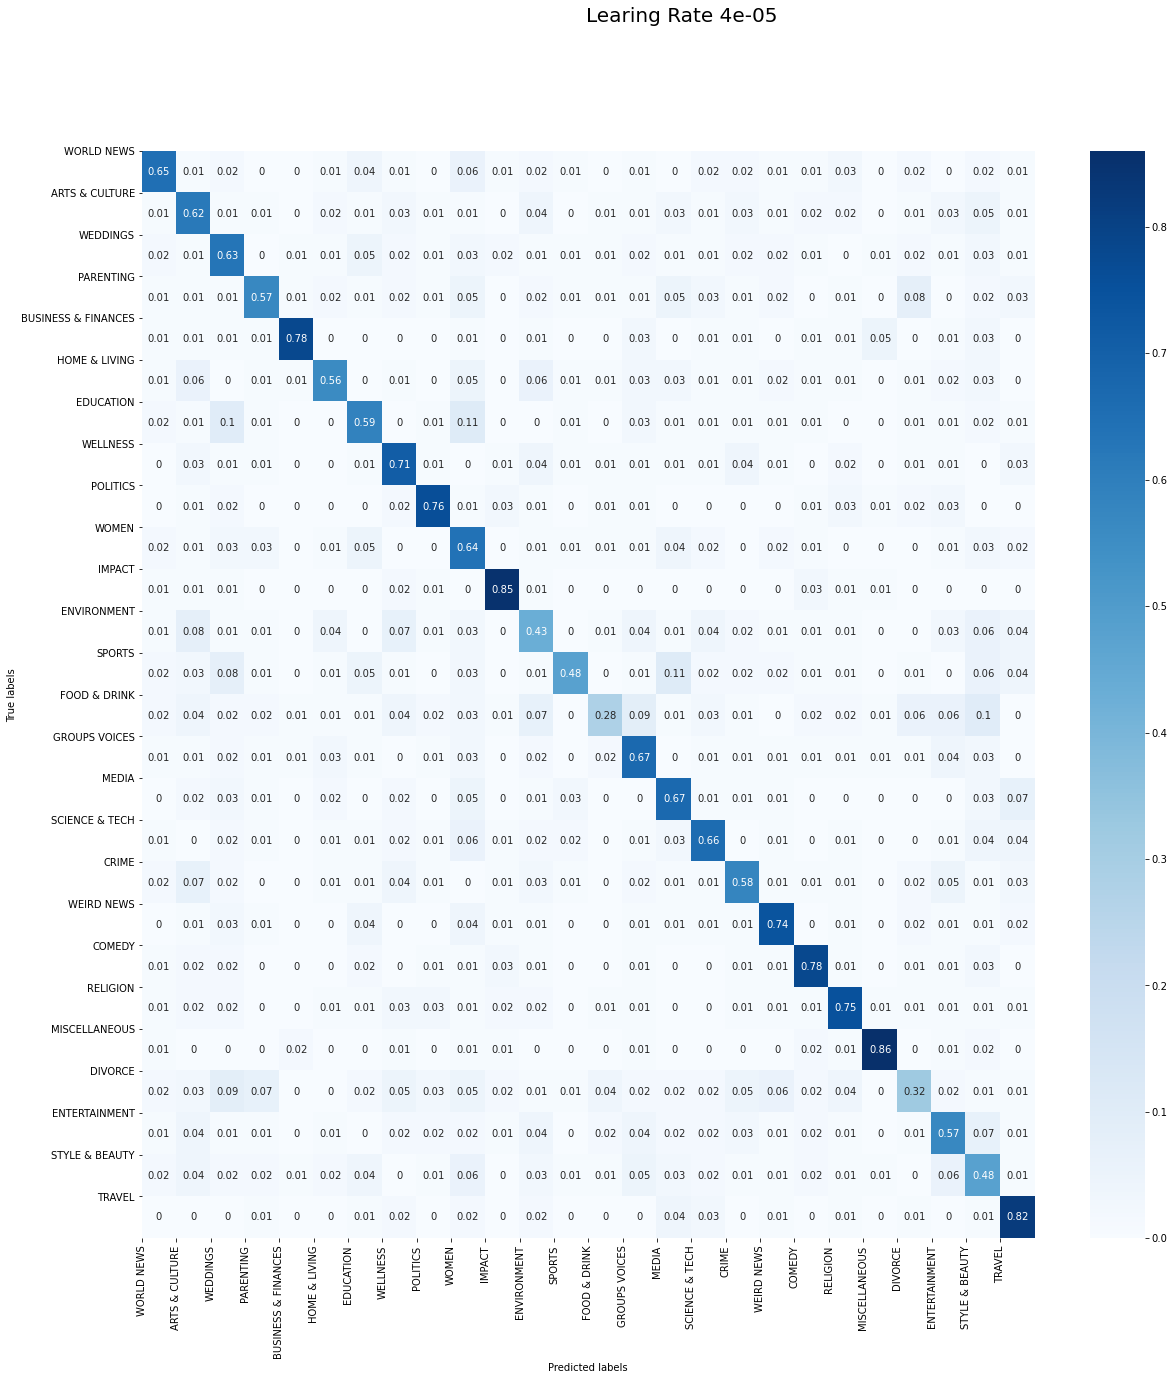

<Figure size 432x288 with 0 Axes>

In [14]:
lset = list(lset)
true_cate = [lset[i] for i in true_labels]
pred_cate = [lset[j] for j in pred_outputs]
# print(true_cate[:20])
# print(pred_cate[:20])
con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)

# === plot ===
fig = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
catee = list(range(0,len(lset),1))
fig.suptitle('Learing Rate '+str(LEARN_RATE),fontsize=20)
plt.xlabel('Predicted labels')
plt.xticks(catee,lset)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catee,lset)
plt.yticks(rotation=360)
plt.show()
plt.savefig('./img/{}-{}-matrix.jpg'.format(LEARN_RATE,MAX_SEQ_LENGTH))